# Imports

In [12]:
import os, sys

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

from sklearn.metrics import classification_report

import evaluate

from datasets import Dataset

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
os.chdir("applied-ml-assignment-5/src")

# Variables

In [4]:
DATA_DIR = "../data/sentiment-analysis"

# Dataset

In [5]:
train_dataset = pd.read_csv(
    os.path.join(DATA_DIR, "train.csv"),
    encoding="unicode_escape",
    usecols=["text", "sentiment"],
)
test_dataset = pd.read_csv(
    os.path.join(DATA_DIR, "test.csv"),
    encoding="unicode_escape",
    usecols=["text", "sentiment"],
)
train_dataset.dropna(inplace=True)
test_dataset.dropna(inplace=True)
train_dataset["label"] = train_dataset["sentiment"].map(
    {"positive": 2, "neutral": 1, "negative": 0}
)
test_dataset["label"] = test_dataset["sentiment"].map(
    {"positive": 2, "neutral": 1, "negative": 0}
)
train = Dataset.from_pandas(train_dataset[["text", "label"]])
test = Dataset.from_pandas(test_dataset[["text", "label"]])

In [6]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained(
    "google-bert/bert-base-cased", num_labels=3
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [11]:
tokenized_train = train.map(tokenize_function, batched=True)
tokenized_test = test.map(tokenize_function, batched=True)

Map:   0%|          | 0/27480 [00:00<?, ? examples/s]

Map:   0%|          | 0/3534 [00:00<?, ? examples/s]

# Training the model

In [14]:
training_args = TrainingArguments(
    output_dir="bert_finetuning", 
    evaluation_strategy="steps", 
    # num_train_epochs=1,
    max_steps=1200,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    logging_steps=50,
    save_steps=100,
    learning_rate=1e-4,
)
metric = evaluate.load("accuracy")


def compute_metrics(eval_predictions):
    logits, labels = eval_predictions
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert_finetuning/checkpoint-500", num_labels=3
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
50,0.579400,0.721341,0.722977
100,0.554200,0.698423,0.729485
150,0.460200,0.716249,0.735144
200,0.603500,0.669625,0.748161
250,0.467900,0.813030,0.728919
300,0.492500,0.787856,0.706848
350,0.506700,0.656891,0.741370
400,0.482100,0.739959,0.723543
450,0.492700,0.704494,0.746180
500,0.586600,0.632028,0.754952


TrainOutput(global_step=1200, training_loss=0.5726881154378255, metrics={'train_runtime': 4433.7053, 'train_samples_per_second': 4.33, 'train_steps_per_second': 0.271, 'total_flos': 5051777620377600.0, 'train_loss': 0.5726881154378255, 'epoch': 0.7})

# Classification results

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert_finetuning/checkpoint-1200", num_labels=3
)
tokenizer = AutoTokenizer.from_pretrained(
    "google-bert/bert-base-cased"
)

In [7]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [9]:
texts = test_dataset["text"].to_list()
all_predictions = []

# forward pass
for i in tqdm(range(0, len(test_dataset["text"]), 32), unit="batch"):
    # Get a batch of texts
    batch_texts = test_dataset["text"][i:i+20].tolist()
    # Tokenize the batch
    batch_inputs = tokenizer(
        batch_texts, 
        padding="max_length", 
        truncation=True, 
        return_tensors="pt"
    ).to(DEVICE)
    
    # Forward pass
    with torch.no_grad():
        # Move model to device if not already there
        model = model.to(DEVICE)
        outputs = model(**batch_inputs)
    # Get predictions for this batch
    batch_predictions = outputs.logits.argmax(dim=-1).tolist()
    # Store predictions
    all_predictions.extend(batch_predictions)
    # Clear GPU memory used by this batch
    del batch_inputs
    del outputs
    torch.cuda.empty_cache()

100%|██████████| 177/177 [01:37<00:00,  1.82batch/s]


In [13]:
print(
    classification_report(
        y_true=test_dataset["label"].to_list(), 
        y_pred=all_predictions, 
        target_names=["negative", "neutral", "positive"]
    )
)

              precision    recall  f1-score   support

    negative       0.77      0.77      0.77      1001
     neutral       0.74      0.74      0.74      1430
    positive       0.82      0.82      0.82      1103

    accuracy                           0.77      3534
   macro avg       0.78      0.78      0.78      3534
weighted avg       0.77      0.77      0.77      3534



## Visualising the training

In [17]:
finetuning_logs = pd.read_csv("finetuning.csv")

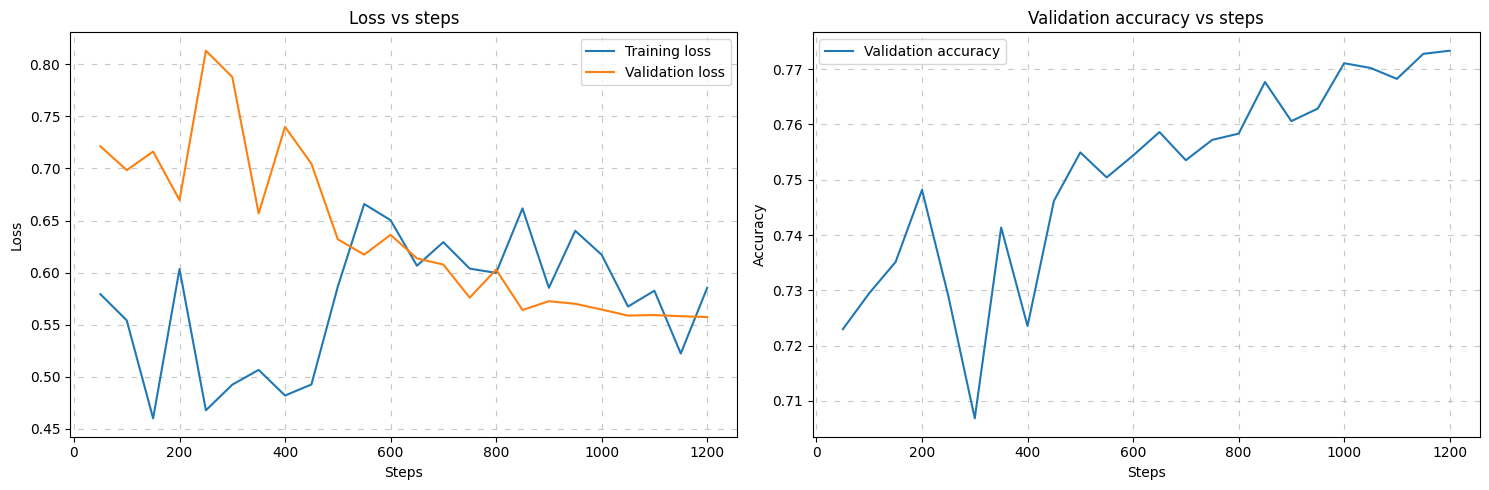

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.lineplot(data=finetuning_logs, x="Step", y="Training Loss", label="Training loss", ax=axs[0])
sns.lineplot(data=finetuning_logs, x="Step", y="Validation Loss", label="Validation loss", ax=axs[0])
axs[0].set_title("Loss vs steps")
axs[0].set_xlabel("Steps")
axs[0].set_ylabel("Loss")

sns.lineplot(data=finetuning_logs, x="Step", y="Accuracy", label="Validation accuracy", ax=axs[1])
axs[1].set_title("Validation accuracy vs steps")
axs[1].set_xlabel("Steps")
axs[1].set_ylabel("Accuracy")

plt.legend()
plt.tight_layout()
axs[0].grid(visible=True, which="major", axis="both", ls=(5, (5, 7)), alpha=0.7)
axs[1].grid(visible=True, which="major", axis="both", ls=(5, (5, 7)), alpha=0.7)
plt.show()